In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_mnist
from trainer import Trainer

from argparse import Namespace


In [2]:
config = {
    'train_ratio': .8,
    'batch_size': 256,
    'n_epochs': 50,
    'verbose': 1,
    'btl_size': 2
}

config = Namespace(**config)

print(config)

Namespace(batch_size=256, btl_size=2, n_epochs=50, train_ratio=0.8, verbose=1)


In [3]:
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** .5), -1)

    plt.imshow(x, cmap='gray')
    plt.show()

In [10]:
train_x, _ = load_mnist()
test_x, test_y = load_mnist(is_train=False)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

# Shuffle dataset to split into train/valid set.
indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(train_x, dim=0, index=indices).split([train_cnt, valid_cnt], dim=0)

print("Train:", train_x.shape)
print("Valid:", valid_x.shape)
print("Test:", test_x.shape)

Train: torch.Size([48000, 784])
Valid: torch.Size([12000, 784])
Test: torch.Size([10000, 784])


In [5]:
from model import Autoencoder

In [6]:
model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [7]:
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss=0.0713 valid_loss=0.0481 lowest_loss=0.0481
Epoch(2/50): train_loss=0.0463 valid_loss=0.0443 lowest_loss=0.0443
Epoch(3/50): train_loss=0.0441 valid_loss=0.0431 lowest_loss=0.0431
Epoch(4/50): train_loss=0.0431 valid_loss=0.0424 lowest_loss=0.0424
Epoch(5/50): train_loss=0.0423 valid_loss=0.0413 lowest_loss=0.0413
Epoch(6/50): train_loss=0.0422 valid_loss=0.0414 lowest_loss=0.0413
Epoch(7/50): train_loss=0.0418 valid_loss=0.0414 lowest_loss=0.0413
Epoch(8/50): train_loss=0.0423 valid_loss=0.0410 lowest_loss=0.0410
Epoch(9/50): train_loss=0.0412 valid_loss=0.0403 lowest_loss=0.0403
Epoch(10/50): train_loss=0.0414 valid_loss=0.0408 lowest_loss=0.0403
Epoch(11/50): train_loss=0.0405 valid_loss=0.0398 lowest_loss=0.0398
Epoch(12/50): train_loss=0.0406 valid_loss=0.0395 lowest_loss=0.0395
Epoch(13/50): train_loss=0.0400 valid_loss=0.0396 lowest_loss=0.0395
Epoch(14/50): train_loss=0.0402 valid_loss=0.0388 lowest_loss=0.0388
Epoch(15/50): train_loss=0.0401 valid_loss=

## Test

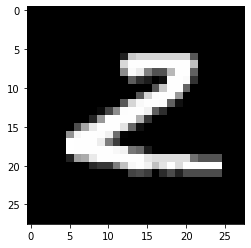

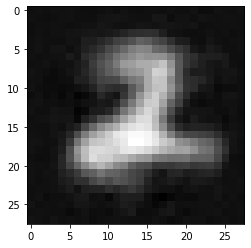

In [8]:
with torch.no_grad():
    import random

    index = int(random.random() * test_x.size(0))

    recon = model(test_x[index].view(1, -1)).squeeze()

    show_image(test_x[index])
    show_image(recon)

## Latent Space

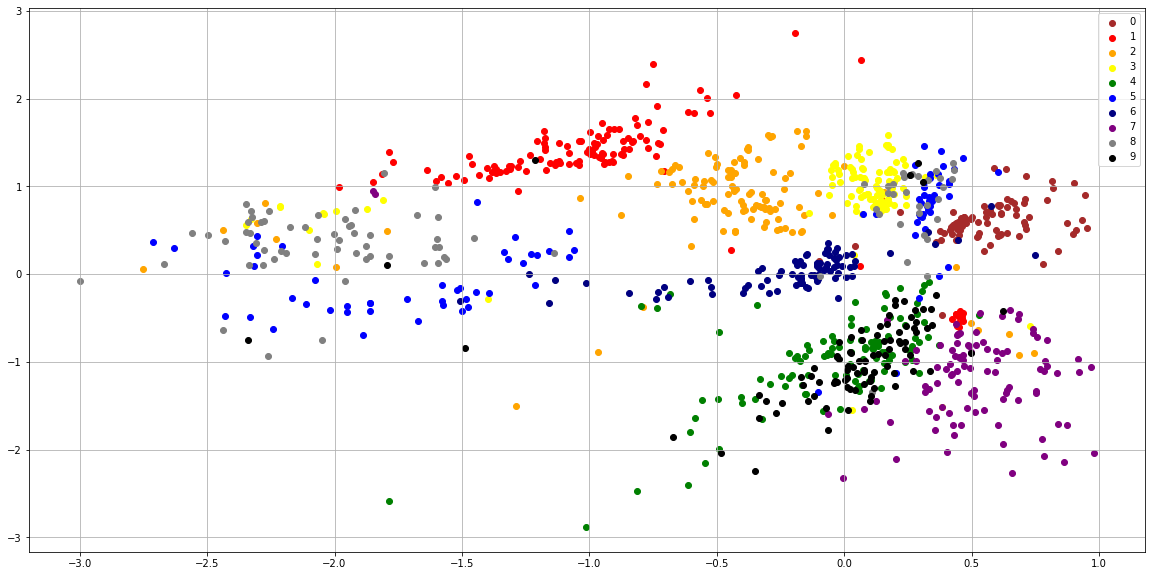

In [11]:
if config.btl_size == 2:
    color_map = [
        'brown', 'red', 'orange', 'yellow', 'green',
        'blue', 'navy', 'purple', 'gray', 'black',
    ]
    
    plt.figure(figsize=(20, 10))
    with torch.no_grad():
        latents = model.encoder(test_x[:1000])
        
        for i in range(10):
            target_latents = latents[test_y[:1000] == i]
            target_y = test_y[:1000][test_y[:1000] == i]
            plt.scatter(target_latents[:, 0],
                        target_latents[:, 1],
                        marker='o',
                        color=color_map[i],
                        label=i)
        
        plt.legend()
        plt.grid(axis='both')
        plt.show()

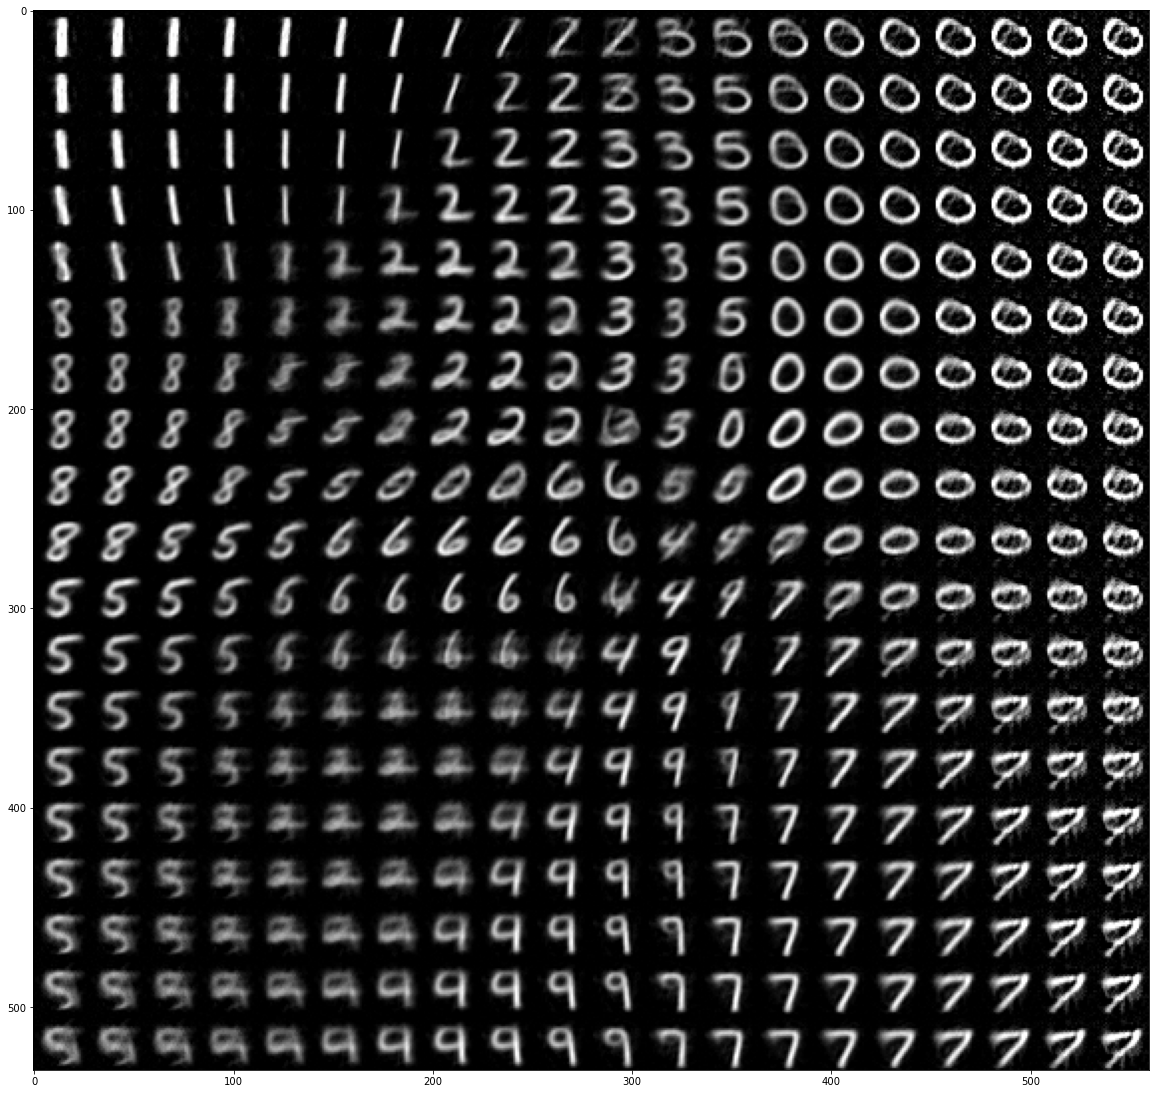

In [12]:
if config.btl_size == 2:
    min_range, max_range = -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []

        for v1 in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([v1] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range,
                                                          max_range, step)]),
            ], dim=-1)
            
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n - 1, 0, -1)], dim=0)
            lines += [line]
            
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_image(lines)